In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import tensorflow_datasets as tfds

tfd = tfp.distributions
tfpl = tfp.layers

# Introduction

This article belongs to the series "Probabilistic Deep Learning". This weekly series covers probabilistic approaches to deep learning. The main goal is to extend deep learning models to quantify uncertainty, i.e. know what they do not know. 

We develop our models using TensorFlow and TensorFlow Probability (TFP). TFP is a Python library built on top of TensorFlow. We are going to start with the basic objects that we can find in TensorFlow Probability (TFP) and understand how can we manipulate them. We will increase complexity incrementally over the following weeks and combine our probabilistic models with deep learning on modern hardware (e.g. GPU).



As usual, the code is available on my GitHub.

# Distribution Objects

In the last article, we saw how to manipulate TFP distribution objects. Remember that distribution objects capture the essential operations on probability distributions. We started with univariate distributions, i.e. distributions with only one random variable. Then, we extended our understanding to how to represent multivariate distributions with the distribution objects properties. We kept it simple as we defined a 2-dimensional Gaussian distribution and did not include any correlation between the two dimensions. The most important properties to recall are the `batch_shape` and `event_shape`. If you are  not comfortable with them yet, please check my previous article. We will  make use of them extensively during this series.

We are going to go through one more concept regarding distribution objects, before moving forward to introducing trainable distribution parameters.

### Independent Distribution

There are cases where we want to interpret a batch of independent distributions over an event space as a single joint distribution over a product of event spaces. This impacts the way we handle the `batch_shape` and `event_shape` properties. The independent distribution will be very useful when we start building some well known algorithms such as the Naive Bayes classifier. The reason is that in the case of Naive Bayes, the features are independent given a class label.

To illustrate, let's define two normal distributions.
The first is a multivariate normal of the form:
$$\begin{align}
\mathcal{N_1} &= (\mu_1,\Sigma_1) \\
\mu_1 &= [0, 1] \\
\Sigma_1 &= \begin{bmatrix}
1 & 0\\
0 & 2
\end{bmatrix}
\end{align}$$


The second is a batched normal of the form:
$$\begin{align}
\mathcal{N_{2_1}} &= (\mu_{2_1},\sigma_{2_1}) \\
\mu_{2_1} &= 0 \\
\sigma_{2_1} &= 1 \\[10pt]
\mathcal{N_{2_2}} &= (\mu_{2_2},\sigma_{2_2}) \\
\mu_{2_2} &= 1 \\
\sigma_{2_2} &= 2
\end{align}$$

To define the first one, we are going to use the `MultivariateNormalDiag` as before, since, once again, the dimensions are not correlated between them.

In [20]:
mv_normal = tfd.MultivariateNormalDiag(loc=[0, 1], scale_diag=[1,2])
mv_normal

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

We are getting comfortable with the shape properties, hence it is no surprise that we have an `event_shape` of 2. 

As usual, we can compute the log probability:

In [16]:
mv_normal.log_prob([0.2, 1.5])

<tf.Tensor: shape=(), dtype=float32, numpy=-2.5822742>

We get a single value, since we have a single distribution despite the fact that it is multidimensional.

Let's sample from our independent multivariate Gaussian distribution and plot the joint distribution. We did something similar before.

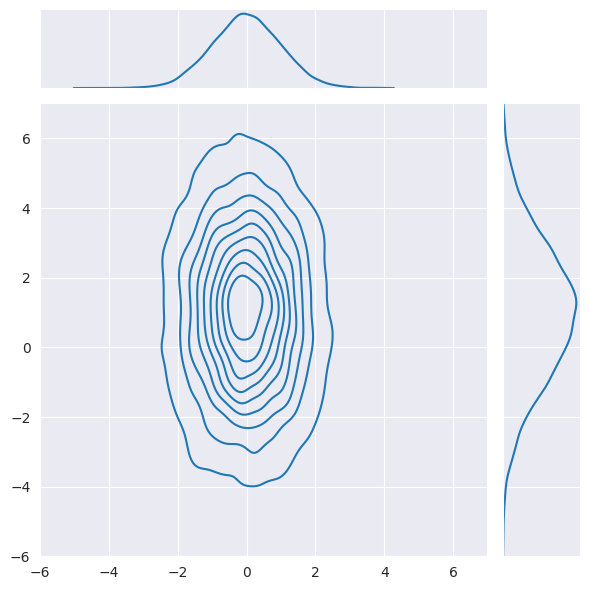

In [15]:
samples = mv_normal.sample(10000).numpy()
x1 = samples[:,0]
x2 = samples[:,1]
sns.jointplot(x = x1, y = x2, kind='kde', xlim=[-6, 7], ylim=[-6, 7]);

As expected, there are no correlations between the dimensions of our multivariate Gaussian distribution.

Time to represent the batched Gaussian distribution object.

In [23]:
locs = [0,1]
scales = [1, 2]

batched_normal = tfd.Normal(loc=locs, scale=scales)
batched_normal

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

Notice the `batch_shape` equal to 2.

In [24]:
batched_normal.log_prob([0.2, 1.5])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.9389385, -1.6433357], dtype=float32)>

As we have two separate distributions stored in the same object, computing the log probability yields two values.

We can plot the PDF of both univariate distributions.

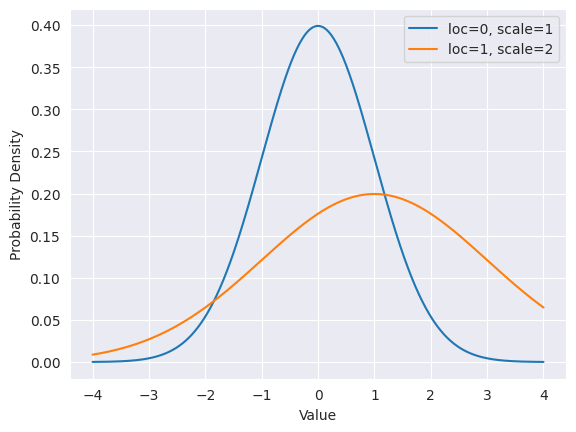

In [29]:
x = np.linspace(-4, 4, 10000)
densities = batched_normal.prob(np.repeat(x[:, np.newaxis], 2, axis=1))

sns.lineplot(x=x, y=densities[:, 0], label=f'loc={locs[0]}, scale={scales[0]}')
sns.lineplot(x=x, y=densities[:, 1], label=f'loc={locs[1]}, scale={scales[1]}')
plt.ylabel('Probability Density')
plt.xlabel('Value')
plt.legend()
plt.show()

Let's wrap up the above, so that we can introduce the independent distribution object. It was clear that while the first distribution object returned a single log-probability the second returned 2. The difference is that the array that we pass to the first is interpreted as a single realization of a 2-dimensional random variable. In the second case, the array is interpreted as different inputs for each of the random variables - the batches.

To help us grasp what is the independent distribution and how it is helpful, let's play with some probabilistic jargon:
* The independent distribution is a simplified way for us to move from univariate distributions to a single multivariate distribution;
* The independent distribution allows us to move from several distributions of a single random variable to a joint distribution of a set of random variables;
* The independent distribution gives the capacity to move from several batched distributions to a single multidimensional distribution;
* The independent distribution is an interface to  absorb whatever dimensions we want to absorb to the event dimension;
* Finally, the more pragmatic and TFP way of describing it - the independent distribution is a way to move batch_shape dimensions of a distribution to the event_shape of a new distribution object.

Hopefully, describing it in so many different ways made all these probabilistic concepts and the way they were translated to TFP abstractions clear.

Time to apply the theoretical concepts and see the practical implementation.

In [30]:
independent_normal = tfd.Independent(batched_normal, reinterpreted_batch_ndims=1)
independent_normal

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

The batched Gaussian distribution is now an `IndependentNormal` distribution object, which is in fact an independent multivariate Gaussian as we defined above. We can see it by the `event_shape` of 2. Similarly, the log probability should yield a single value now.

In [31]:
independent_normal.log_prob([0.2, 1.5])

<tf.Tensor: shape=(), dtype=float32, numpy=-2.5822742>

Finally, let's compare the plot of the independent Gaussian distribution with the one that we showed above.

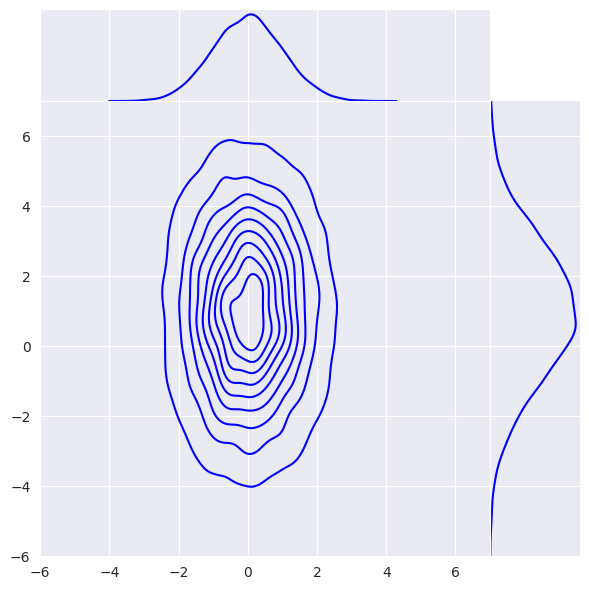

In [32]:
samples = independent_normal.sample(10000).numpy()
x1 = samples[:,0]
x2 = samples[:,1]
sns.jointplot(x = x1, y = x2, kind='kde', space=0, color='b', xlim=[-6, 7], ylim=[-6, 7]);

# Trainable Parameters

### Variables

Now that we know what TensorFlow Probability objects are, it is time to understand how we can train parameters for these distributions. This is the connection that we are missing to start applying what we have learned and building algorithms.

In TensorFlow, `Variable` objects are what we use to capture the values of the parameters of our deep learning models. These objects are updated during training by, for example, applying gradients obtained from a loss function and data.

Let's define one. Note that to create a new variable, we have to provide an initial value.

In [43]:
init_vals = tf.constant([[1.0, 2.0], [3.0, 4.0]])
new_variable = tf.Variable(init_vals)
new_variable

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>

A `Variable` is very similar to a tensor. They have similar properties such as shape and dtype and methods, e.g. export to NumPy.

In [44]:
print("shape: ", new_variable.shape)
print("dType: ", new_variable.dtype)
print("as NumPy: ", new_variable.numpy())
print("Index of highest value:", tf.math.argmax(new_variable))

shape:  (2, 2)
dType:  <dtype: 'float32'>
as NumPy:  [[1. 2.]
 [3. 4.]]
Index of highest value: tf.Tensor([1 1], shape=(2,), dtype=int64)


Note that if for some reason you do not want a variable to be differentiated, you can its argument to false .

In [45]:
variable_not_diff = tf.Variable(1, trainable=False)
variable_not_diff

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>

Anyway, usually we want our variables to be differentiated. TensorFlow allows automatic differentiation, which is the foundational piece to backpropagation for training neural networks. 

There is an API that we will use to accomplish the automatic differentiation - `tf.GradientTape`. Connecting back to the `Variable` object, this API gives us the ability to compute the gradient of an operation with respect to our inputs, i.e. one or more `Variable` objects.

Let's do a quick example using `tf.GradientTape` API and the `Variable` object.

In [46]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

Once we defined an operation inside the `tf.GradientTape` context, we can call the `gradient` method and pass the loss and the input variables.

In [48]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

Time to apply these concepts to our problem. Recall that we are interested in learning parameters of a distribution.

In [49]:
normal = tfd.Normal(loc=tf.Variable(0., name='loc'), scale=5)
normal.trainable_variables

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=0.0>,)

In this case, the mean of the Gaussian distribution defined above is no longer a simple value but a `Variable` object that can be learned.

For the training procedure, Maximum Likelihood is the usual suspect in deep learning models. In a nutshell, we are looking for the parameters of our model that maximize the probability of the data. 

The probability density function of a continuous random variable roughly indicates the probability of a sample taking a particular value. We will denote this function $P(x | \theta)$ where $x$ is the value of the sample and $\theta$ is the parameter describing the probability distribution:

$$
P(x | \theta) = \text{Prob} (\text{sampling value $x$ from a distribution with parameter $\theta$}).
$$

In [35]:
tfd.Normal(0, 1).prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3989423>

It may seem fancy, but in fact we have been computing the PDF of Gaussian distributions for a while now, so nothing particularly new here.

To finalize this introduction to training parameters, let's connect this concept with the independent distribution objects that we also shared above. When more than one sample is drawn *independently* from the same distribution (which we usually assume), the PDF of the sample values $x_1, \ldots, x_n$ is the product of the PDFs for each individual $x_i$. We can write it as:

$$
P(x_1, \ldots, x_n | \theta) = \prod_{i=1}^n P(x_i | \theta).
$$

Hopefully, you see how both concepts overlap in the above definition.

# Conclusion

This article continued to explore distribution objects in TFP but this time connecting it with the `Variable` object from TensforFlow. We started by defining what an independent distribution is and how can it help us defining independent joint probabilities. It allows us to move from univariate distributions to an independent multivariate distribution, thus absorbing whatever dimensions we want to absorb to the event dimension. Next, we introduced the `Variable` objects and how can we differentiate them. With that knowledge we used them in conjunction with a distribution object from TFP. Finally, we talked about the Maximum Likelihood procedure and how it relates to the independent joint distribution when we sample independently from the same distribution.

Next week, we will explore the training procedure for distributions in more detail. See you then!

# References and Materials

[1] - [Coursera: TensorFlow 2 for Deep Learning Specialization](https://www.coursera.org/specializations/tensorflow2-deeplearning)

[2] - [Coursera: Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning)

[3] - [TensorFlow Probability Guides and Tutorials](https://www.tensorflow.org/probability/overview)

[4] - [TensorFlow Probability Posts in TensorFlow Blog](https://blog.tensorflow.org/search?label=TensorFlow+Probability&max-results=20)